In [1]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Классификация фамилий по национальности

In [2]:
from google.colab import files
#Подгрузка файлов
uploaded = files.upload()

Saving surnames.csv to surnames.csv


Заменить национальности на численное представление(0-17).

In [3]:
datastart=pd.read_csv('surnames.csv')
data=datastart.copy()
data['nationality'] = pd.factorize(datastart['nationality'])[0]; data

,surname,nationality
0,Woodford,0
1,Coté,1
2,Kore,0
3,Koury,2
4,Lebzak,3
...,...,...
10975,Quraishi,2
10976,Innalls,0
10977,Król,12
10978,Purvis,0


Важно сохранить правильную индексацию для обратной расшифровки.

In [4]:
nationalities=[]
for i in range(18):
  nationalities.append(list(datastart['nationality'])[list(data['nationality']).index(i)])
nationalities

['English',
 'French',
 'Arabic',
 'Russian',
 'Japanese',
 'Chinese',
 'Italian',
 'Czech',
 'Irish',
 'German',
 'Greek',
 'Spanish',
 'Polish',
 'Dutch',
 'Vietnamese',
 'Korean',
 'Portuguese',
 'Scottish']

Предобрабатываем фамилии:
Удаляем пунктуацию, цифры
Приведим к нижнему регистру

In [5]:
def preprocess_text(text: str):
    x = []
    x.append(re.sub(r"[.,!?\\'-/:]+|[\d]+", " ", text.lower()))
    x=word_tokenize(x[0])
    return x
data['surname'] =[preprocess_text(i) for i in data['surname']]

Создаем два класса, которые делают датасет с векторным представлением фамилий.За основу взят принцип токенизации встречающихся в фамилии букв.
Длина вектора - количество встречающихся во всех фамилий выборки букв.
Национальности так же являются векторным представлением категориальных данных.

In [6]:
class Vocab:
  def __init__(self, X):
    self.token=set(list(''.join(set([i[0] for i in data['surname']]))))
    self.idx = range(len(self.token))
    self.idx_to_token = dict(zip(self.idx, self.token))
    self.token_to_idx = dict(zip(self.token, self.idx))
    self.vocab_len = len(self.idx_to_token)

class SurnamesDataset(Dataset):
  def __init__(self, X, y, vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname):
    '''Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2)'''
    vector = torch.zeros(self.vocab.vocab_len, dtype=torch.float32)
    for l in surname:
      vector[self.vocab.token_to_idx[l]] = 1
    return vector
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.vectorize(self.X[idx])
    y = torch.tensor(self.y[idx], dtype=torch.float32)
    return X, y

In [81]:
dataset = SurnamesDataset([i[0] for i in data['surname']], to_categorical(data.nationality,18),Vocab([i[0] for i in data['surname']]))

Разбиваем данные на обучающую и тестовую выборки.
Создаем нейронную сеть с 3 линейными слоями

In [82]:
dataset_train_size = round(len(dataset)*0.8)
dataset_test_size = len(dataset) - dataset_train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [dataset_train_size, dataset_test_size])
batch_size=2048
num_epochs = 100
num_classes = 18
learning_rate = 0.001
trainloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset=dataset_test, batch_size=batch_size)

In [83]:
class Classifier(nn.Module):
  def __init__(self, input_features, output_features):
    super(Classifier, self).__init__()
    self.layer1 = nn.Linear(input_features, 128)
    self.batchnorm1 = nn.BatchNorm1d(128)
    self.layer2 = nn.Linear(128, 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.layer3 = nn.Linear(64, output_features)
    self.drop_out = nn.Dropout()

  def forward(self, x, training=False):
    x = self.layer1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.drop_out(x)
    x = self.layer2(x)
    x = self.batchnorm2(x)
    x = self.drop_out(x)
    x = F.relu(x)
    x = self.layer3(x)
    x = F.softmax(x, dim=1)
    return x

model = Classifier(dataset_train[0][0].size(0), dataset_train[0][1].size(0))

In [84]:
model

Classifier(
  (layer1): Linear(in_features=50, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=64, out_features=18, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

In [85]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Функция по нахождению accuracy для тестовых данных.

In [86]:
def test_accuracy(model,dataloader):
  criterion = nn.CrossEntropyLoss()
  model.eval()
  accuracy = 0
  epoch_loss=0
  with torch.no_grad():
    for X_batch, y_batch in dataloader:
      y_pred = model(X_batch)
      loss = criterion(y_pred, y_batch)
      y_batch = torch.argmax(y_batch, axis=1)
      y_pred = torch.argmax(y_pred, axis=1)
      accuracy += torch.sum(y_batch == y_pred)
      epoch_loss += loss.item()
  accuracy = accuracy.item() / len(dataloader.dataset)
  return accuracy, epoch_loss

Обучаем модель, смотрим на значение ошибки и accuracy на обучающих данных и тествовых по эпохам.

In [49]:
total_step = len(trainloader)
loss_list = []
for epoch in range(num_epochs):
  for i, (X, y) in enumerate(trainloader,0):
    outputs = model(X,training=True)
    loss = criterion(outputs, y)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total = y.size(0)
  if (epoch%10==0):
    train_accuracy_,train_loss = test_accuracy(model,trainloader)
    print('Epoch [{}/{}], Loss: {:.4f}, trainAccuracy: {:.2f}%'
    .format(epoch + 1, num_epochs,(train_loss/len(trainloader)), train_accuracy_* 100))
    test_accuracy_,test_loss = test_accuracy(model,valloader)
    print('Loss: {:.4f}, testAccuracy: {:.2f}%'.format((test_loss/len(valloader)), test_accuracy_* 100))

Epoch [1/100], Loss: 2.8875, trainAccuracy: 20.87%
Loss: 2.8873, testAccuracy: 20.36%
Epoch [11/100], Loss: 2.5994, trainAccuracy: 40.21%
Loss: 2.5977, testAccuracy: 40.21%
Epoch [21/100], Loss: 2.5138, trainAccuracy: 48.10%
Loss: 2.5161, testAccuracy: 46.63%
Epoch [31/100], Loss: 2.4758, trainAccuracy: 51.08%
Loss: 2.4998, testAccuracy: 49.04%
Epoch [41/100], Loss: 2.4677, trainAccuracy: 52.07%
Loss: 2.4924, testAccuracy: 49.54%
Epoch [51/100], Loss: 2.4588, trainAccuracy: 52.76%
Loss: 2.4861, testAccuracy: 50.18%
Epoch [61/100], Loss: 2.4516, trainAccuracy: 53.55%
Loss: 2.4815, testAccuracy: 50.73%
Epoch [71/100], Loss: 2.4434, trainAccuracy: 54.05%
Loss: 2.4751, testAccuracy: 51.23%
Epoch [81/100], Loss: 2.4444, trainAccuracy: 54.77%
Loss: 2.4712, testAccuracy: 51.87%
Epoch [91/100], Loss: 2.4332, trainAccuracy: 55.26%
Loss: 2.4674, testAccuracy: 52.09%


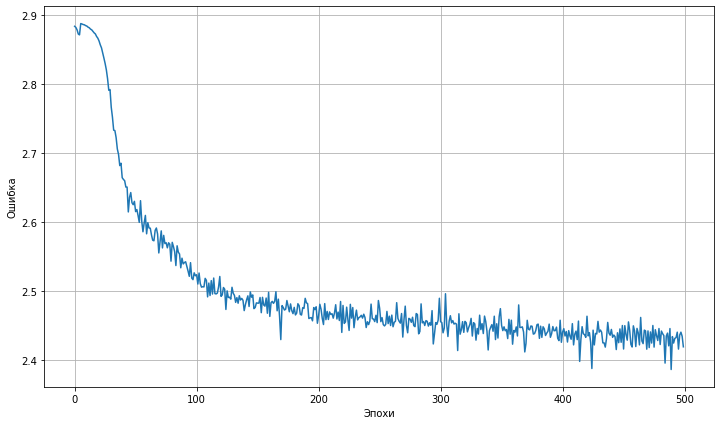

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(range(500), loss_list)
plt.xlabel("Эпохи")
plt.ylabel("Ошибка")
plt.grid(True)

Посмотрим на работу обученной модели, изучим оценки предпологаемой принадлежности фамилий.

In [51]:
def vectorize(vocab, surname):
  vector = torch.zeros(vocab.vocab_len, dtype=torch.float32)
  for l in surname:
    vector[vocab.token_to_idx[l]] = 1
  return vector

In [72]:
surnames = ['ahmed','ahmad','smerov','petrov','hossain','aetos','ali','gao']
posnations=[torch.topk(model(j.unsqueeze(0)),3) for j in [vectorize(Vocab([i for i in data['surname']]),i) for i in surnames]]
for i, surname in enumerate(surnames):
  print(surname)
  for j in range(3):
    print(nationalities[posnations[i][1].tolist()[0][j]],posnations[i][0].tolist()[0][j])

ahmed
Arabic 0.9510058760643005
English 0.048992328345775604
Chinese 4.961567583450233e-07
ahmad
Arabic 0.9999706745147705
English 2.8928912797709927e-05
Korean 1.4615409327234374e-07
smerov
Russian 0.6929647922515869
English 0.3070344626903534
Chinese 3.4983798968823976e-07
petrov
Russian 0.984321117401123
English 0.015678873285651207
Chinese 3.705740436732441e-10
hossain
Arabic 0.3852175772190094
Russian 0.384768545627594
English 0.2299588918685913
aetos
English 0.9995896220207214
Arabic 0.00040998609620146453
Chinese 1.3209141513925715e-07
ali
English 0.5507639646530151
Arabic 0.44921875
Chinese 5.546308784687426e-06
gao
English 0.5444383025169373
Arabic 0.4554699659347534
Chinese 2.5125458705588244e-05


In [80]:
datastart.groupby('nationality').nunique()

,surname
nationality,
Arabic,108
Chinese,205
Czech,403
Dutch,228
English,2972
French,224
German,562
Greek,150
Irish,180


Построенная модель дает осознанные результаты, однако ее качество не очень хорошее. Виден сильный сдвиг в сторону Английских, Русских фамилий, которые модель определяет правильно, но приписывает лишние. Причиной этого вероятно является проблема несбалансированности выборки. Русских и Английских в несколько раз больше, чем остальных.